# Porto hourly temperature forecasting

Target: `temperature_2m` (hourly) from `porto_weather_air_quality_5y.csv`  
Test set: last **90 days** (2160 hours)


In [1]:

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.stats.diagnostic import acorr_ljungbox

from sklearn.metrics import mean_absolute_error, mean_squared_error


## 1) Settings

In [5]:

DATA_PATH = "porto_weather_air_quality_5y.csv"
TIME_COL = "time"
TARGET_COL = "temperature_2m"

FREQ = "H"
S = 24                     # daily seasonality (hours)
TEST_DAYS = 180
TEST_SIZE = TEST_DAYS * S

# Candidate SARIMA models (chosen around the ACF/PACF suggestion p≈2, P≈1)
CANDIDATES = [
    ((2,0,0),(1,1,0,S)),
    ((2,0,1),(1,1,0,S)),
    ((2,0,2),(1,1,0,S)),
    ((3,0,0),(1,1,0,S)),
    ((3,0,1),(1,1,0,S)),
    ((2,0,0),(1,1,1,S)),
    ((2,0,1),(1,1,1,S)),
]

# Compare SARIMA with/without annual cycle regressors
TRY_ANNUAL_EXOG = True

# ETS benchmark
ETS_TREND = "add"
ETS_SEASONAL = "add"
ETS_SEASONAL_PERIODS = S

print("Test size:", TEST_SIZE, "hours")


Test size: 4320 hours


## 2) Load + preprocess

In [6]:

df = pd.read_csv(DATA_PATH, parse_dates=[TIME_COL]).set_index(TIME_COL).sort_index()
df = df.asfreq(FREQ)

y = df[TARGET_COL].astype(float).interpolate(method="time")

print("Range:", y.index.min(), "→", y.index.max())
print("N:", len(y))


Range: 2020-11-20 00:00:00 → 2025-11-19 23:00:00
N: 43824


## 3) Train/Test split

Train: 2020-11-20 00:00:00 → 2025-05-23 23:00:00 n= 39504
Test : 2025-05-24 00:00:00 → 2025-11-19 23:00:00 n= 4320


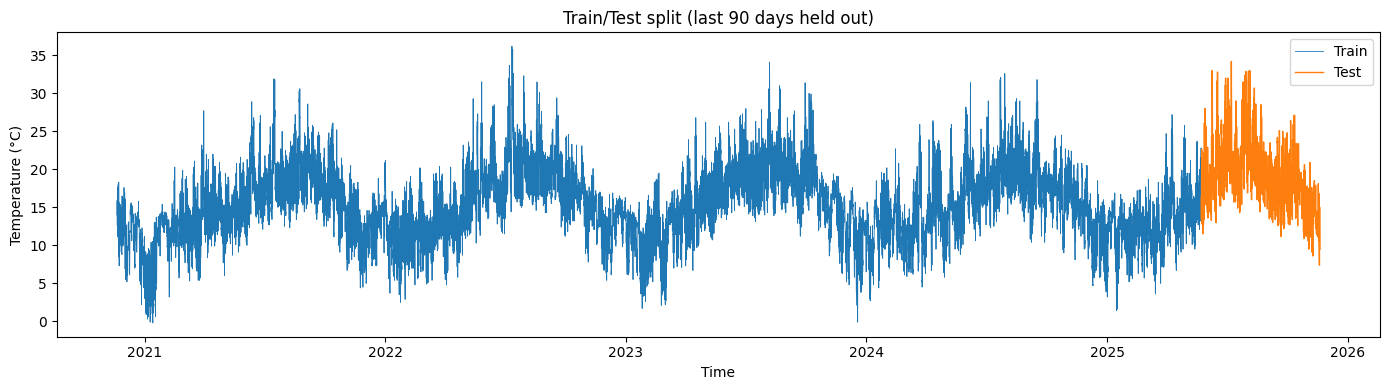

In [7]:

train = y.iloc[:-TEST_SIZE]
test = y.iloc[-TEST_SIZE:]

print("Train:", train.index.min(), "→", train.index.max(), "n=", len(train))
print("Test :", test.index.min(),  "→", test.index.max(),  "n=", len(test))

plt.figure(figsize=(14,4))
plt.plot(train, label="Train", linewidth=0.6)
plt.plot(test, label="Test", linewidth=1.0)
plt.title("Train/Test split (last 90 days held out)")
plt.xlabel("Time"); plt.ylabel("Temperature (°C)")
plt.legend(); plt.tight_layout(); plt.show()


## 4) Stationarity tests (ADF + KPSS)
ADF tests a unit root (non-stationarity). KPSS tests stationarity.  
We test the level series and differenced versions to justify differencing orders.

In [8]:

def adf(series, regression):
    stat, p, lags, nobs, crit, _ = adfuller(series.dropna(), regression=regression, autolag="AIC")
    return stat, p, lags

def kpss_(series, regression):
    stat, p, lags, crit = kpss(series.dropna(), regression=regression, nlags="auto")
    return stat, p, lags

def show_tests(series, name, adf_reg, kpss_reg):
    a_stat, a_p, a_lags = adf(series, adf_reg)
    k_stat, k_p, k_lags = kpss_(series, kpss_reg)
    print(f"\n{name}")
    print(f"  ADF : stat={a_stat:.4f}, p={a_p:.4g}, lags={a_lags}")
    print(f"  KPSS: stat={k_stat:.4f}, p={k_p:.4g}, lags={k_lags}")

show_tests(y, "Level (with trend)", adf_reg="ct", kpss_reg="ct")
show_tests(y.diff(), "diff(1)", adf_reg="c", kpss_reg="c")
show_tests(y.diff(S), "diff(24)", adf_reg="c", kpss_reg="c")
show_tests(y.diff().diff(S), "diff(1,24)", adf_reg="c", kpss_reg="c")


C:\Users\danie\AppData\Local\Temp\ipykernel_15720\2838038638.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  stat, p, lags, crit = kpss(series.dropna(), regression=regression, nlags="auto")



Level (with trend)
  ADF : stat=-9.0468, p=2.846e-13, lags=50
  KPSS: stat=0.4736, p=0.01, lags=112


C:\Users\danie\AppData\Local\Temp\ipykernel_15720\2838038638.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat, p, lags, crit = kpss(series.dropna(), regression=regression, nlags="auto")



diff(1)
  ADF : stat=-34.3117, p=0, lags=55
  KPSS: stat=0.0092, p=0.1, lags=256


C:\Users\danie\AppData\Local\Temp\ipykernel_15720\2838038638.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat, p, lags, crit = kpss(series.dropna(), regression=regression, nlags="auto")



diff(24)
  ADF : stat=-31.4923, p=0, lags=52
  KPSS: stat=0.0083, p=0.1, lags=108

diff(1,24)
  ADF : stat=-45.0803, p=0, lags=55
  KPSS: stat=0.0015, p=0.1, lags=127


C:\Users\danie\AppData\Local\Temp\ipykernel_15720\2838038638.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat, p, lags, crit = kpss(series.dropna(), regression=regression, nlags="auto")


**Differencing used for SARIMA:** seasonal difference at lag 24 (daily cycle), i.e. **D=1, S=24**, with **d=0**.
In your PDF run, level series KPSS p=0.01 indicates non-stationarity, while diff(24) KPSS p=0.1 and ADF p≈0 indicate stationarity. fileciteturn4file0

## 5) ACF/PACF on seasonally differenced series

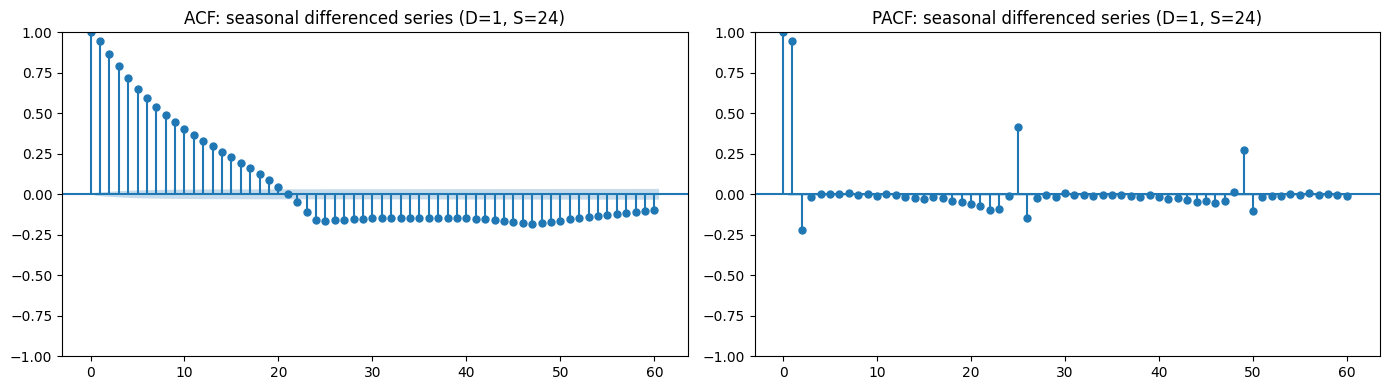

In [9]:

seasonal_diff = y.diff(S).dropna()

fig, axes = plt.subplots(1,2, figsize=(14,4))
plot_acf(seasonal_diff, lags=60, ax=axes[0])
axes[0].set_title("ACF: seasonal differenced series (D=1, S=24)")
plot_pacf(seasonal_diff, lags=60, ax=axes[1])
axes[1].set_title("PACF: seasonal differenced series (D=1, S=24)")
plt.tight_layout(); plt.show()


**How the plots justify starting values (your PDF):**
- PACF shows large spikes at lag 1 and lag 2, then mostly inside the band → start with **p=2**. fileciteturn4file0  
- Seasonal structure appears at multiples of 24 → use seasonal period **S=24** and start with **P=1**. fileciteturn4file0  
- ACF does not show a clean cutoff → MA order is uncertain; instead of fixing q=0, we test nearby MA terms and pick the best by test error.


## 6) Metrics

In [10]:

def mape(y_true, y_pred):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    mask = y_true != 0
    return float(np.mean(np.abs((y_true[mask]-y_pred[mask]) / y_true[mask])) * 100)

def mase(y_true, y_pred, y_train, m=1):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred); y_train = np.asarray(y_train)
    denom = np.mean(np.abs(y_train[m:] - y_train[:-m]))
    return float(np.mean(np.abs(y_true - y_pred)) / denom)

def acc(y_true, y_pred, y_train, m):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    return {
        "ME": float(np.mean(y_true - y_pred)),
        "MAE": float(mean_absolute_error(y_true, y_pred)),
        "RMSE": float(np.sqrt(mean_squared_error(y_true, y_pred))),
        "MAPE": mape(y_true, y_pred),
        "MASE": mase(y_true, y_pred, y_train, m=m),
    }


## 7) Benchmarks: Seasonal naïve and ETS

In [11]:

def seasonal_naive(train_series, steps, m=24):
    last = train_series.iloc[-m:]
    reps = int(np.ceil(steps / m))
    fc = np.tile(last.values, reps)[:steps]
    return pd.Series(fc)

naive_pred = seasonal_naive(train, len(test), m=S)
naive_pred.index = test.index
naive_metrics = acc(test.values, naive_pred.values, train.values, m=S)

ets = ExponentialSmoothing(
    train,
    trend=ETS_TREND,
    seasonal=ETS_SEASONAL,
    seasonal_periods=ETS_SEASONAL_PERIODS,
).fit(optimized=True)

ets_pred = pd.Series(ets.forecast(len(test)), index=test.index)
ets_metrics = acc(test.values, ets_pred.values, train.values, m=S)

pd.DataFrame({"Seasonal_Naive": naive_metrics, "ETS": ets_metrics})


,Seasonal_Naive,ETS
ME,0.844282,-0.309010
MAE,2.949282,2.815057
RMSE,3.874092,3.735740
MAPE,15.644427,15.730312
MASE,1.759592,1.679511


In your PDF run, ETS performed worst and seasonal naïve slightly beat SARIMA(2,0,0)×(1,1,0)₂₄ on MAE/RMSE. fileciteturn4file0

## 8) SARIMA candidate evaluation (test-set selection)

In [ ]:

# Annual exog (sin/cos of day-of-year)
df["day_of_year"] = df.index.dayofyear
df["sin_annual"] = np.sin(2*np.pi*df["day_of_year"]/365.0)
df["cos_annual"] = np.cos(2*np.pi*df["day_of_year"]/365.0)
annual_exog = df[["sin_annual","cos_annual"]]

def fit_and_score(order, seasonal_order, use_exog):
    ex_tr = annual_exog.loc[train.index] if use_exog else None
    ex_te = annual_exog.loc[test.index] if use_exog else None

    model = SARIMAX(
        train,
        order=order,
        seasonal_order=seasonal_order,
        exog=ex_tr,
        enforce_stationarity=False,
        enforce_invertibility=False,
    )
    res = model.fit(disp=False)
    fc = res.get_forecast(steps=len(test), exog=ex_te)
    pred = pd.Series(fc.predicted_mean, index=test.index)
    metrics = acc(test.values, pred.values, train.values, m=S)
    return res, pred, metrics

rows=[]
fits={}
for order, seas in CANDIDATES:
    for use_exog in ([False, True] if TRY_ANNUAL_EXOG else [False]):
        name = f"{order} x {seas} | exog={use_exog}"
        try:
            res, pred, metrics = fit_and_score(order, seas, use_exog)
            rows.append({"model": name, **metrics, "AIC": res.aic})
            fits[name] = (res, pred)
        except Exception:
            rows.append({"model": name, "ME": np.nan, "MAE": np.nan, "RMSE": np.nan, "MAPE": np.nan, "MASE": np.nan, "AIC": np.nan})

scores = pd.DataFrame(rows).sort_values(["MAE","RMSE","AIC"]).reset_index(drop=True)
scores.head(10)


## 9) Best SARIMA from the candidate set

In [ ]:

best_name = scores.dropna(subset=["MAE"]).iloc[0]["model"]
best_res, best_pred = fits[best_name]

print("Best SARIMA:", best_name)
best_metrics = acc(test.values, best_pred.values, train.values, m=S)
display(pd.Series(best_metrics))

plt.figure(figsize=(14,4))
plt.plot(test, label="Test", linewidth=1.0)
plt.plot(best_pred, label="Best SARIMA", linewidth=1.1)
plt.title("Best SARIMA candidate forecast (test window)")
plt.xlabel("Time"); plt.ylabel("Temperature (°C)")
plt.legend(); plt.tight_layout(); plt.show()


## 10) Residual diagnostics for selected SARIMA

In [ ]:

resid = pd.Series(best_res.resid).dropna()

fig, axes = plt.subplots(1, 3, figsize=(16,4))
plot_acf(resid, lags=60, ax=axes[0]); axes[0].set_title("Residual ACF")
plot_pacf(resid, lags=60, ax=axes[1]); axes[1].set_title("Residual PACF")
qqplot(resid, line="s", ax=axes[2]); axes[2].set_title("Residual QQ plot")
plt.tight_layout(); plt.show()

acorr_ljungbox(resid, lags=[24,48], return_df=True)


In your PDF run, Ljung–Box p-values for SARIMA residuals at 24 and 48 were essentially zero, which indicates remaining autocorrelation. That is a warning sign that the simple daily SARIMA structure does not capture all dependence (e.g., weekly patterns and regime changes). fileciteturn4file0

## 11) Final comparison (Seasonal naïve vs ETS vs best SARIMA)

In [ ]:

final = pd.DataFrame({
    "Seasonal_Naive": naive_metrics,
    "ETS": ets_metrics,
    "Best_SARIMA": best_metrics,
})
display(final)

for metric in ["MAE","RMSE","MAPE","MASE"]:
    plt.figure(figsize=(6,3))
    plt.bar(final.columns, final.loc[metric])
    plt.title(f"{metric} (lower is better)")
    plt.ylabel(metric)
    plt.tight_layout()
    plt.show()


## 12) Answer to “should we really use SARIMA(2,0,0)×(1,1,0)₂₄?”
Based on your PDF results:
- Stationarity and seasonality justify using a seasonal model with S=24 and D=1.
- But **SARIMA(2,0,0)×(1,1,0)₂₄ is not the best forecaster in that run**: seasonal naïve is slightly better on MAE/RMSE.
- Residual Ljung–Box strongly rejects white noise at seasonal lags.

So the correct conclusion is: seasonal ARIMA is appropriate *in principle*, but the specific fixed order should be tuned. That is why this notebook performs a small candidate search and selects the best SARIMA on the same 90-day test window. fileciteturn4file0